In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dados = pd.read_csv("dados/datatx_tratado_t_f")
dados.head()

,text_processado,label_T_F
0,anonymous loosely associated international net...,1
1,washington reuters u president donald trump as...,0
2,london reuters british foreign minister boris ...,0
3,know donald trump appeals calls poorly educate...,1
4,washington reuters four conservative u republi...,0


In [3]:
from sklearn.model_selection import train_test_split

X = dados['text_processado']
y = dados['label_T_F']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 45)

In [4]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

510
122


In [5]:
X_train = X_train.fillna('')

In [6]:
X_test = X_test.fillna('')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features= 5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Aplicando L2 para tentar evitar Overfiting

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C=1.0,
                           class_weight='balanced', random_state=42,
                           max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [9]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)
print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Acurácia: 0.9897550111358575
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4254
           1       0.99      0.99      0.99      4726

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [10]:
y_train_pred = model.predict(X_train_tfidf)
train_acc = accuracy_score(y_train, y_train_pred)

print(f'Acurácia de Treinamento: {train_acc}')
print(classification_report(y_train, y_train_pred))

Acurácia de Treinamento: 0.9913692299125787
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17163
           1       0.99      0.99      0.99     18755

    accuracy                           0.99     35918
   macro avg       0.99      0.99      0.99     35918
weighted avg       0.99      0.99      0.99     35918



In [11]:
import re
import nltk
from nltk.corpus import stopwords

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def preprocess_words(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W', ' ', text)
    
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [14]:
def predict_fakenews(text):
    text = preprocess_words(text)
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)
    
    return "Fake" if prediction[0] == 1 else "Verdade"

In [15]:
amostra_titulo = "Mauro Vieira diz que Brasil não romperá relação com Israel: “Acreditamos no diálogo”"

print(predict_fakenews(amostra_titulo))

Fake


#### Acesso a url

In [16]:
import requests
from bs4 import BeautifulSoup

In [17]:
def extrair_texto_url(url):
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        texto = ' '.join([p.get_text() for p in soup.find_all('p')])
        
        return texto
    
    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar a URL {url}: {e}")
        return None

In [18]:
#texto_extraido_url = extrair_texto_url("https://www.aljazeera.com/news/2024/10/24/israel-strikes-syrian-capital-damascus-military-site-near-homs")

text_teste = "World Health Organization Declares End of COVID-19 Global Health Emergency: The World Health Organization (WHO) officially declared an end to the global health emergency status of the COVID-19 pandemic, citing a significant decrease in cases and global vaccination efforts as the basis for their decision."


print(predict_fakenews(text_teste))

Fake


## Resolvendo possivel problema de overfitting

In [19]:
dados['label_T_F'].value_counts()

label_T_F
1    23481
0    21417
Name: count, dtype: int64

<Axes: xlabel='label_T_F'>

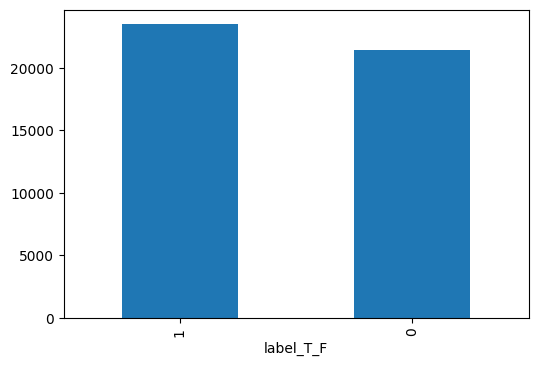

In [20]:
dados['label_T_F'].value_counts().plot(kind='bar', figsize=(6, 4))

In [21]:
print("Porcentagem de desbalanço: : %.2f%%" % (1 - (21417 / 23481)))

Porcentagem de desbalanço: : 0.09%


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

In [23]:
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

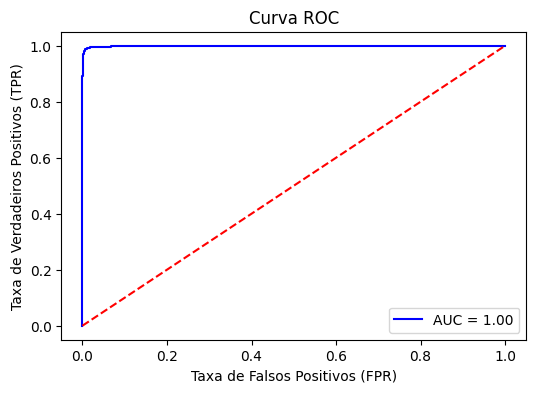

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha de referência
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

#### DummyClassifier linha base

In [25]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(X_train_tfidf, y_train)
acuracia = dummy_stratified.score(X_test_tfidf, y_test) * 100

print("A acurácia do dummy stratified foi de %.2f%%" % acuracia)

A acurácia do dummy stratified foi de 49.54%


### Utilizando K-fold Cross-Validation para validação mais robusta

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [27]:
def imprime_resultados(results):
    media =results.mean() 
    desvio_padrao = results.std()
    print("Accuracy média: %.2f" % (media * 100))
    print("Accuracy com cross validation, intervalo: [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

In [28]:
print(X_train_tfidf.shape)
print(y.shape)

(35918, 5000)
(44898,)


In [29]:
X.isna().value_counts()

text_processado
False    44266
True       632
Name: count, dtype: int64

In [30]:
x_no_null = X.fillna('')

In [31]:
X_cross = vectorizer.fit_transform(x_no_null)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(penalty='l2', C=1.0,
                           class_weight='balanced', random_state=42,
                           max_iter=1000)
results = cross_val_score(model, X_cross, y, cv= cv, scoring='accuracy')
imprime_resultados(results)

Accuracy média: 98.76
Accuracy com cross validation, intervalo: [98.58, 98.95]


### Verificando desenpenho e proximidade dos dados de Treinamento e Teste

In [32]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X_cross, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

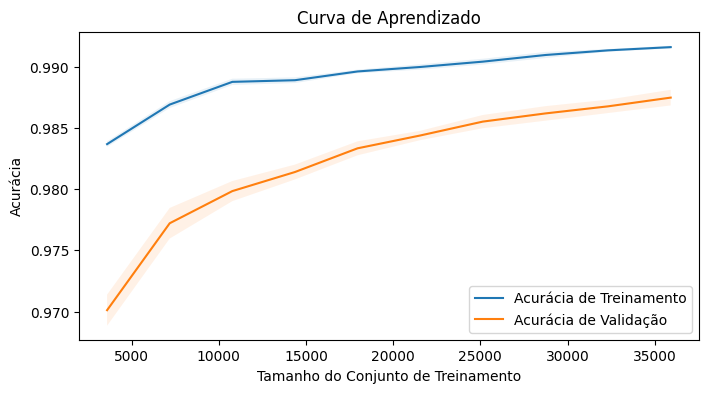

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_scores_mean, label="Acurácia de Treinamento")
plt.plot(train_sizes, val_scores_mean, label="Acurácia de Validação")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1)
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("Acurácia")
plt.title("Curva de Aprendizado")
plt.legend(loc="best")
plt.show()

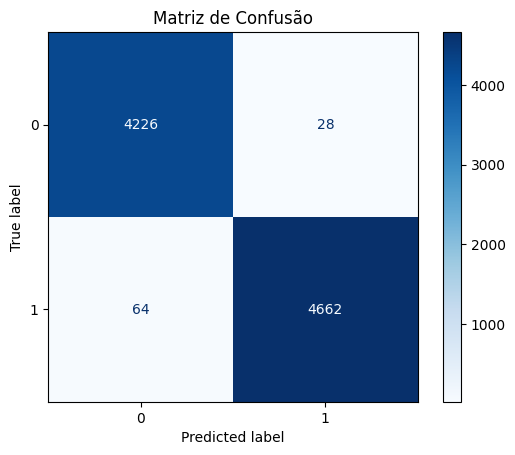

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

## Testes Modelo

In [37]:
text_teste = "https://www.azcentral.com/story/money/business/2024/10/17/tsmc-will-start-making-chips-in-phoenix-in-early-next-year-in-a-sign-of-progressthe-chips-that-power/75714550007/"
#extrair_texto_url()

print(predict_fakenews(extrair_texto_url(text_teste)))

Fake


In [39]:
texto_teste = "The space agency announced that new data collected by the Perseverance rover indicates the presence of liquid water in a Martian crater, suggesting past conditions favorable for life."

predict_fakenews(texto_teste)

'Fake'